Load and inspect the Jena weather dataset.

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-01-20 19:01:05--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.15.6, 52.217.200.72, 52.217.204.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.15.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  39.2MB/s    in 0.3s    

2024-01-20 19:01:05 (39.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Parsing the data

In [3]:
import numpy as np

temperature = np.zeros(len(lines))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]  # Assuming temperature is the first value
    raw_data[i, :] = values[:]


Plotting the temperature timeseries.

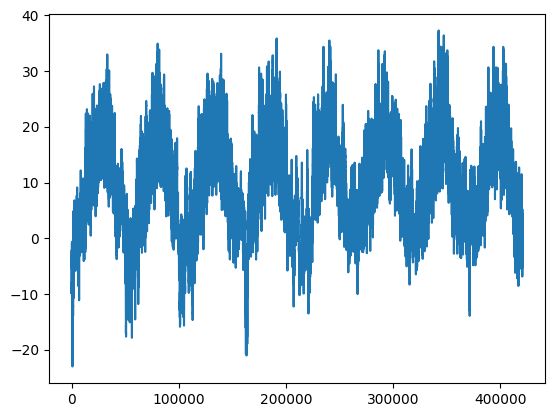

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

Plotting the first ten days of the temperature time series.

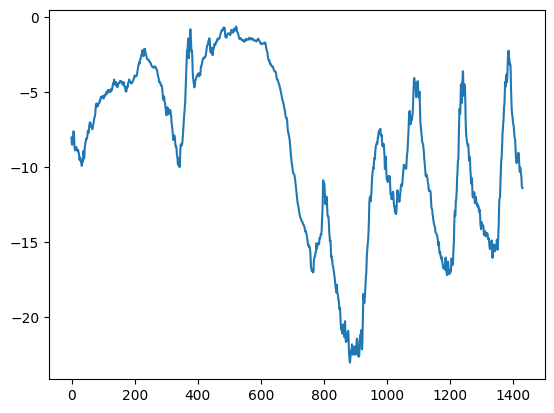

In [5]:
plt.plot(range(1430), temperature[:1430])

Computing the number of samples we'll use for each data split

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("Number of training samples", num_train_samples)
print("Number of validation samples", num_val_samples)
print("Number of test samples", num_test_samples)


Number of training samples 210225
Number of validation samples 105112
Number of test samples 105114


Normalizing the data

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


Instantiating datasets for training, validation, and testing

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256


In [9]:
from tensorflow import keras
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

In [10]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

In [11]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

Inspecting the output of one of our datasets

In [12]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


Data has been processed and samples separated. First let's compute a common sense baseline MAE.

In [13]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")



Validation MAE: 2.44
Test MAE: 2.62


Now lets train and evaluate a densely connected model.

In [14]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 61s 73ms/step - loss: 11.8296 - mae: 2.6688 - val_loss: 10.5357 - val_mae: 2.5726
Epoch 2/10
819/819 [==============================] - 59s 71ms/step - loss: 8.7986 - mae: 2.3355 - val_loss: 10.9515 - val_mae: 2.6175
Epoch 3/10
819/819 [==============================] - 56s 68ms/step - loss: 8.1374 - mae: 2.2475 - val_loss: 10.6771 - val_mae: 2.5804
Epoch 4/10
819/819 [==============================] - 56s 68ms/step - loss: 7.6960 - mae: 2.1866 - val_loss: 10.4123 - val_mae: 2.5411
Epoch 5/10
819/819 [==============================] - 61s 73ms/step - loss: 7.4258 - mae: 2.1471 - val_loss: 10.5950 - val_mae: 2.5693
Epoch 6/10
819/819 [==============================] - 58s 70ms/step - loss: 7.1994 - mae: 2.1148 - val_loss: 11.6203 - val_mae: 2.6858
Epoch 7/10
819/819 [==============================] - 50s 61ms/step - loss: 6.9936 - mae: 2.0852 - val_loss: 10.7549 - val_mae: 2.5813
Epoch 8/10
819/819 [==============================] - 

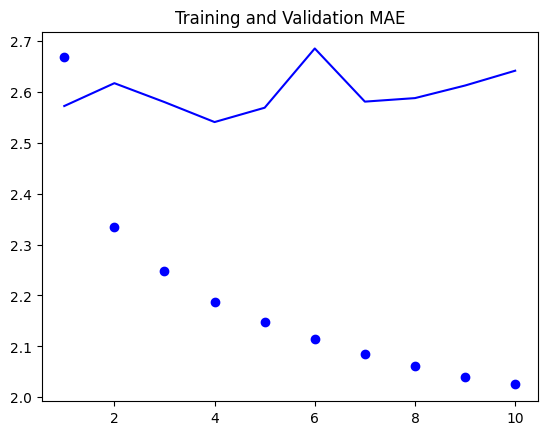

In [15]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.show()

Our model validation MAE is close to the "No-learning baseline" determined earlier. Let's try to refine using a 1D convolutional model.

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 97s 117ms/step - loss: 22.2284 - mae: 3.6939 - val_loss: 14.8903 - val_mae: 3.0541
Epoch 2/10
819/819 [==============================] - 93s 113ms/step - loss: 15.3077 - mae: 3.1066 - val_loss: 15.0232 - val_mae: 3.0636
Epoch 3/10
819/819 [==============================] - 98s 120ms/step - loss: 13.9599 - mae: 2.9605 - val_loss: 14.9825 - val_mae: 3.0917
Epoch 4/10
819/819 [==============================] - 94s 114ms/step - loss: 13.0126 - mae: 2.8493 - val_loss: 16.0681 - val_mae: 3.1828
Epoch 5/10
819/819 [==============================] - 92s 112ms/step - loss: 12.2578 - mae: 2.7585 - val_loss: 14.4320 - val_mae: 3.0192
Epoch 6/10
819/819 [==============================] - 96s 117ms/step - loss: 11.6638 - mae: 2.6852 - val_loss: 15.4501 - val_mae: 3.1003
Epoch 7/10
819/819 [==============================] - 116s 141ms/step - loss: 11.2105 - mae: 2.6344 - val_loss: 14.8960 - val_mae: 3.0437
Epoch 8/10
819/819 [====================

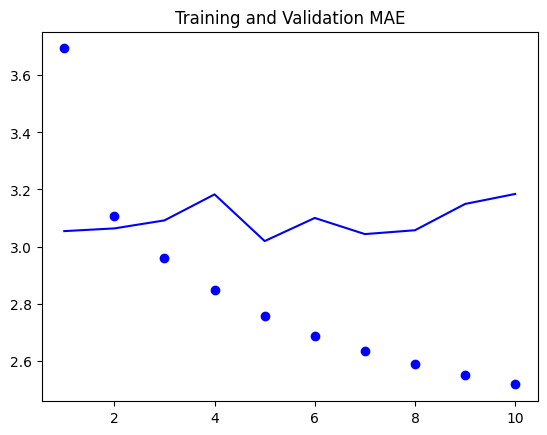

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.show()

Oh no! Our validation MAE is even worse than before. Now let's try a LTSM-based RNN model

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 140s 167ms/step - loss: 40.2071 - mae: 4.5873 - val_loss: 12.0055 - val_mae: 2.6542
Epoch 2/10
819/819 [==============================] - 139s 169ms/step - loss: 10.8368 - mae: 2.5625 - val_loss: 9.8731 - val_mae: 2.4519
Epoch 3/10
819/819 [==============================] - 139s 169ms/step - loss: 9.8787 - mae: 2.4539 - val_loss: 9.7185 - val_mae: 2.4209
Epoch 4/10
819/819 [==============================] - 138s 168ms/step - loss: 9.4727 - mae: 2.4020 - val_loss: 9.8563 - val_mae: 2.4297
Epoch 5/10
819/819 [==============================] - 136s 166ms/step - loss: 9.1248 - mae: 2.3578 - val_loss: 9.8199 - val_mae: 2.4375
Epoch 6/10
819/819 [==============================] - 123s 150ms/step - loss: 8.8311 - mae: 2.3176 - val_loss: 10.0783 - val_mae: 2.4565
Epoch 7/10
819/819 [==============================] - 139s 170ms/step - loss: 8.5856 - mae: 2.2845 - val_loss: 9.6782 - val_mae: 2.4152
Epoch 8/10
819/819 [========================

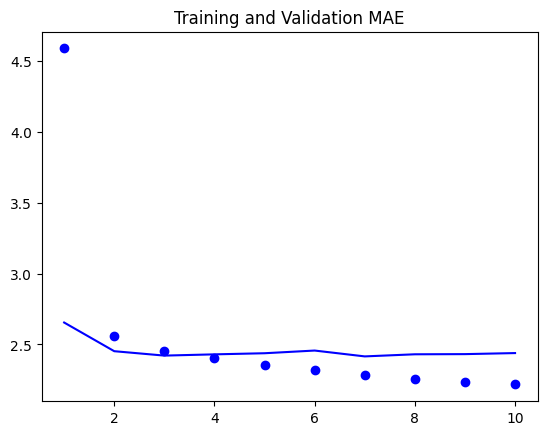

In [19]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.show()

Now the model performs much better! However, its evident that that the model is quickly overfitting. Now to use recurrent dropout to fight overfitting.

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 255s 307ms/step - loss: 27.3174 - mae: 3.8634 - val_loss: 9.7735 - val_mae: 2.4376
Epoch 2/50
819/819 [==============================] - 251s 307ms/step - loss: 14.7356 - mae: 2.9797 - val_loss: 9.6317 - val_mae: 2.4206
Epoch 3/50
819/819 [==============================] - 243s 296ms/step - loss: 13.7776 - mae: 2.8831 - val_loss: 9.3238 - val_mae: 2.3687
Epoch 4/50
819/819 [==============================] - 252s 307ms/step - loss: 13.0961 - mae: 2.8115 - val_loss: 9.3148 - val_mae: 2.3632
Epoch 5/50
819/819 [==============================] - 254s 310ms/step - loss: 12.6103 - mae: 2.7579 - val_loss: 9.5667 - val_mae: 2.4013
Epoch 6/50
819/819 [==============================] - 253s 308ms/step - loss: 12.2236 - mae: 2.7123 - val_loss: 9.2926 - val_mae: 2.3644
Epoch 7/50
819/819 [==============================] - 252s 308ms/step - loss: 11.9336 - mae: 2.6824 - val_loss: 9.2891 - val_mae: 2.3636
Epoch 8/50
819/819 [=====================

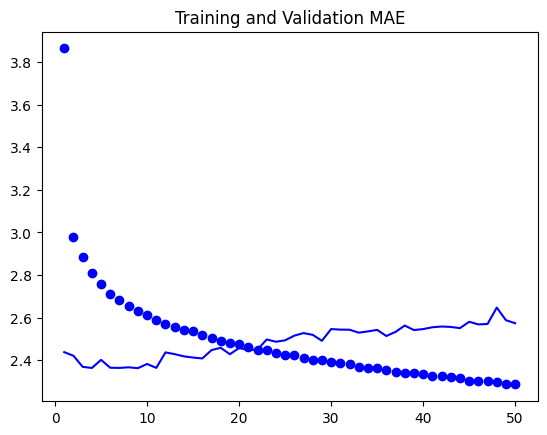

In [21]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.show()

Our validation loss and MAE are now much better! Let's see how stacking RNN layers can further improve the model. We will use Gated Recurrent Unit (GRU) instead of LTSM for this task.



In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")



Epoch 1/50
819/819 [==============================] - 464s 560ms/step - loss: 25.1969 - mae: 3.7065 - val_loss: 9.5978 - val_mae: 2.4005
Epoch 2/50
819/819 [==============================] - 456s 556ms/step - loss: 14.0176 - mae: 2.9027 - val_loss: 8.8374 - val_mae: 2.3005
Epoch 3/50
819/819 [==============================] - 453s 553ms/step - loss: 13.2903 - mae: 2.8213 - val_loss: 9.4546 - val_mae: 2.3910
Epoch 4/50
819/819 [==============================] - 454s 553ms/step - loss: 12.6869 - mae: 2.7587 - val_loss: 8.9721 - val_mae: 2.3271
Epoch 5/50
819/819 [==============================] - 452s 551ms/step - loss: 12.1701 - mae: 2.7051 - val_loss: 8.9348 - val_mae: 2.3196
Epoch 6/50
819/819 [==============================] - 452s 552ms/step - loss: 11.7686 - mae: 2.6602 - val_loss: 9.7209 - val_mae: 2.4148
Epoch 7/50
819/819 [==============================] - 439s 536ms/step - loss: 11.3281 - mae: 2.6119 - val_loss: 8.9568 - val_mae: 2.3200
Epoch 8/50
819/819 [=====================

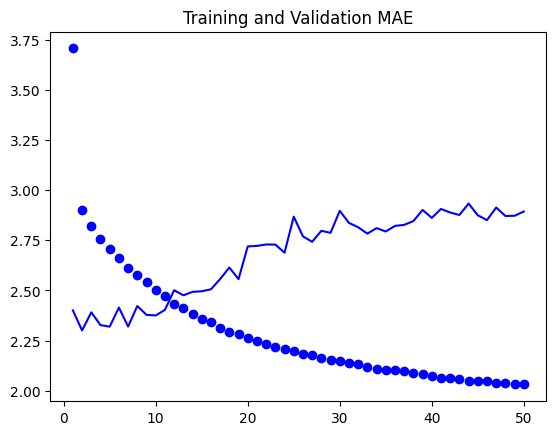

In [23]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.show()

Our model performance is even better! Now finally let's test a bidirectional LSTM to see if their are insights that can by gained by processing our sequences both chonologically and antichronologically.

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_bidirectional.keras", save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 171s 203ms/step - loss: 27.8853 - mae: 3.7784 - val_loss: 11.0380 - val_mae: 2.5831
Epoch 2/10
819/819 [==============================] - 168s 205ms/step - loss: 9.6725 - mae: 2.4313 - val_loss: 9.4423 - val_mae: 2.3853
Epoch 3/10
819/819 [==============================] - 166s 203ms/step - loss: 8.7172 - mae: 2.3040 - val_loss: 9.8084 - val_mae: 2.4148
Epoch 4/10
819/819 [==============================] - 175s 214ms/step - loss: 8.1654 - mae: 2.2326 - val_loss: 9.8778 - val_mae: 2.4218
Epoch 5/10
819/819 [==============================] - 176s 214ms/step - loss: 7.7704 - mae: 2.1773 - val_loss: 10.0896 - val_mae: 2.4437
Epoch 6/10
819/819 [==============================] - 176s 214ms/step - loss: 7.4982 - mae: 2.1373 - val_loss: 10.0984 - val_mae: 2.4561
Epoch 7/10
819/819 [==============================] - 167s 203ms/step - loss: 7.2714 - mae: 2.1046 - val_loss: 10.7334 - val_mae: 2.5148
Epoch 8/10
819/819 [=======================

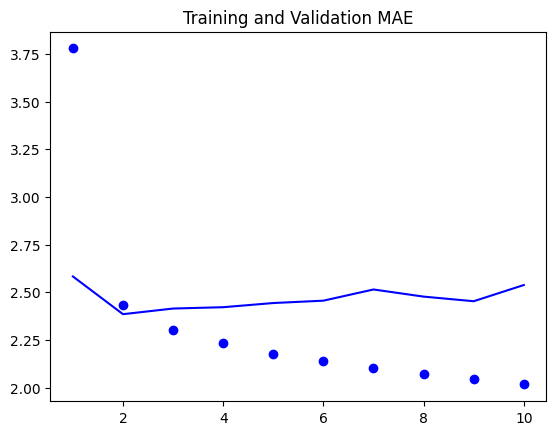

In [25]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.show()

Our regular LSTM model performs much better than the bidirectional model. This likely because the insights from chronological order are essential to our prediction quality with more recent insights given a higher weight, which are being muddied by the antichronological order. Our best model is the stacked GRU RNN with dropout because it is able to encapsulate and pass forward regularized insights gained from the chronological order, better than what our baseline model could produce! However, the compute cost difference was significant. 